In [2]:
import numpy as np
import pandas as pd
import scorecardpy as sc
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [3]:
# Read data; exclude extra faulty column
df = pd.read_csv(r'C:\Users\justi\Documents\Finantier\finantier_data_technical_test_dataset.csv', names = list(range(0,21)))
df.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Default
1,4808-GHDJN,Female,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
3,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
4,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes


In [4]:
df.shape

(7049, 21)

In [5]:
# Set first row as column names and customerID as index for identifier
df = df.rename(columns=df.iloc[0]).drop(df.index[0]).reset_index(drop=True)
df = df.set_index('customerID')

In [6]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Default
customerID,,,,,,,,,,,,,,,,,,,,
4808-GHDJN,Female,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.3,1840.75,No


In [7]:
# Remove rows with all NAs
df = df.dropna(axis=0, how='all')
df.shape

(7044, 20)

In [8]:
# Check if index is unique
df.index.is_unique

True

In [9]:
# Check for missing 'Default' data and remove
df.isnull().sum(axis=0)

gender              0
SeniorCitizen       1
Partner             1
Dependents          1
tenure              1
PhoneService        1
MultipleLines       1
InternetService     1
OnlineSecurity      1
OnlineBackup        1
DeviceProtection    1
TechSupport         1
StreamingTV         1
StreamingMovies     1
Contract            1
PaperlessBilling    1
PaymentMethod       1
MonthlyCharges      1
TotalCharges        1
Default             1
dtype: int64

In [10]:
# Drop missing 'Default' row
df = df[df['Default'].notna()]

In [11]:
df[['MonthlyCharges','TotalCharges']].to_csv(r'C:\Users\justi\Documents\Finantier\montotcharges.csv')

In [12]:
# Force numeric columns as to_numeric() and downcast to float
df['tenure'] = pd.to_numeric(df['tenure'], downcast="float", errors='coerce')
df['MonthlyCharges'] = pd.to_numeric(df['MonthlyCharges'], downcast="float", errors='coerce')
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], downcast="float", errors='coerce')

In [13]:
# For missing TotalCharges, copy MonthlyCharges value 
df['TotalCharges'] = df['TotalCharges'].fillna(df['MonthlyCharges'])

In [14]:
# Change Default column to 1 for Yes and 0 for No
df['Default'] = df['Default'].replace({'Yes':1, 'No':0})

# Binning

In [15]:
df_s = sc.var_filter(df, y='Default')

[INFO] filtering variables ...


In [16]:
# breaking df into train and test
train, test = sc.split_df(df_s, 'Default').values()

In [17]:
# woe binning ------
bins = sc.woebin(df_s, y='Default')

[INFO] creating woe binning ...


{'OnlineBackup': <Figure size 432x288 with 2 Axes>,
 'OnlineSecurity': <Figure size 432x288 with 2 Axes>,
 'StreamingTV': <Figure size 432x288 with 2 Axes>,
 'Contract': <Figure size 432x288 with 2 Axes>,
 'TotalCharges': <Figure size 432x288 with 2 Axes>,
 'StreamingMovies': <Figure size 432x288 with 2 Axes>,
 'SeniorCitizen': <Figure size 432x288 with 2 Axes>,
 'InternetService': <Figure size 432x288 with 2 Axes>,
 'MonthlyCharges': <Figure size 432x288 with 2 Axes>,
 'tenure': <Figure size 432x288 with 2 Axes>,
 'DeviceProtection': <Figure size 432x288 with 2 Axes>,
 'TechSupport': <Figure size 432x288 with 2 Axes>,
 'Dependents': <Figure size 432x288 with 2 Axes>,
 'PaperlessBilling': <Figure size 432x288 with 2 Axes>,
 'PaymentMethod': <Figure size 432x288 with 2 Axes>,
 'Partner': <Figure size 432x288 with 2 Axes>}

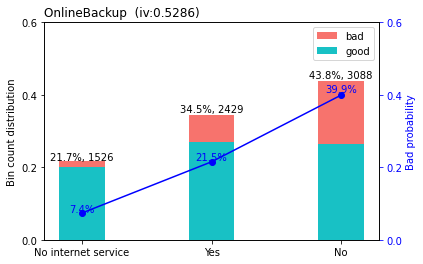

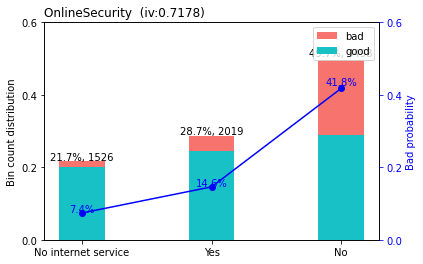

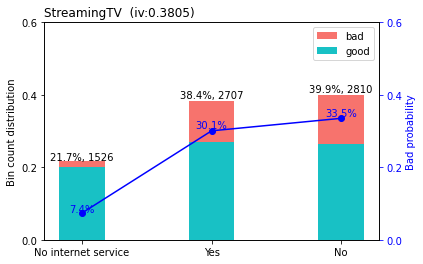

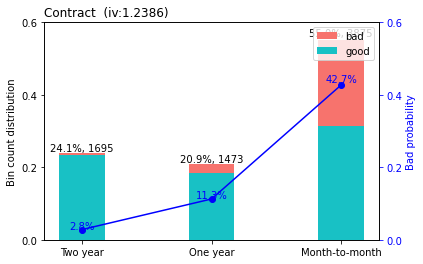

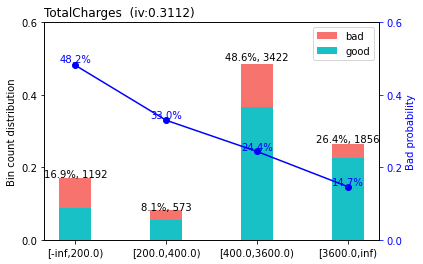

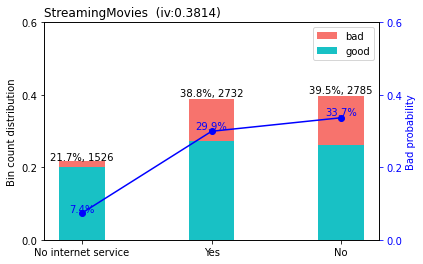

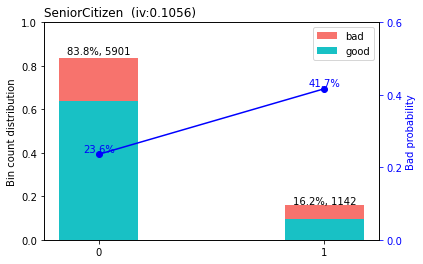

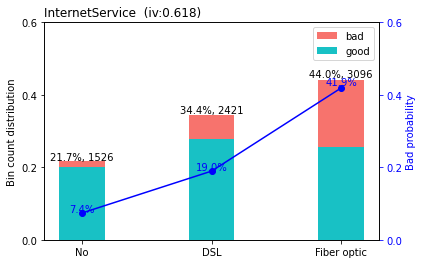

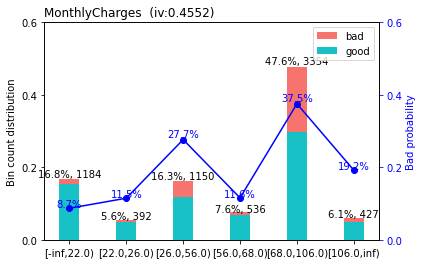

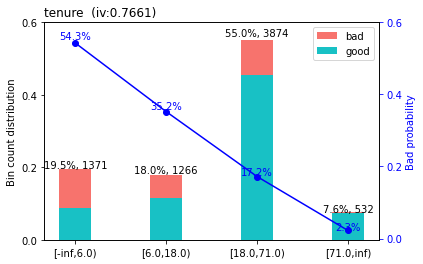

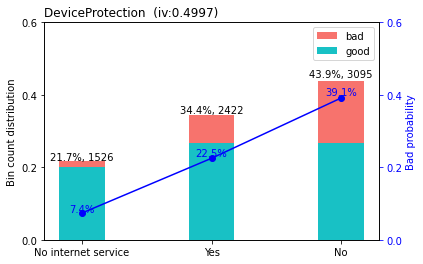

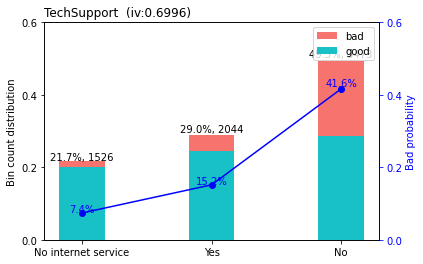

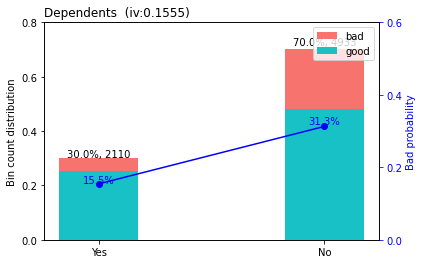

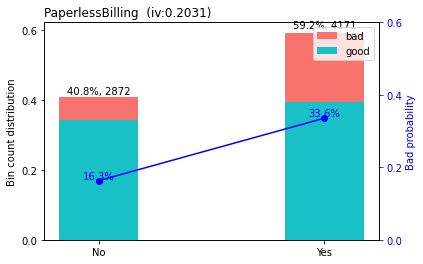

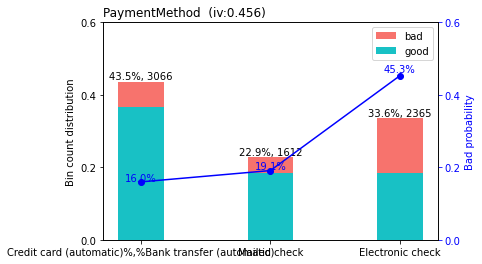

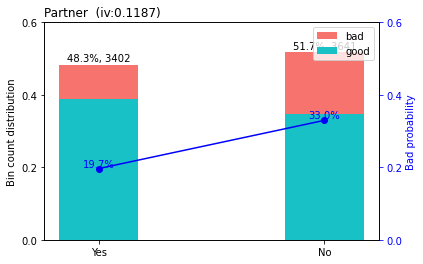

In [18]:
sc.woebin_plot(bins)

-------- 1/8 DeviceProtection --------
>>> dt[DeviceProtection].describe(): 
count     7043
unique       3
top         No
freq      3095
Name: DeviceProtection, dtype: object 

>>> dt[DeviceProtection].value_counts(): 
No                     3095
Yes                    2422
No internet service    1526
Name: DeviceProtection, dtype: int64 

>>> Current breaks:
'No internet service','Yes','No' 



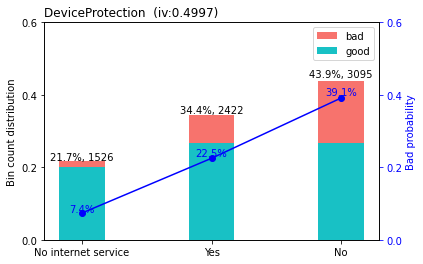

>>> Adjust breaks for (1/8) DeviceProtection?
1: next 
2: yes 
3: back
Selection: 1
-------- 2/8 MonthlyCharges --------
>>> dt[MonthlyCharges].describe(): 
count    7043.000000
mean       64.761826
std        30.089973
min        18.250000
25%        35.500000
50%        70.349998
75%        89.849998
max       118.750000
Name: MonthlyCharges, dtype: float64 



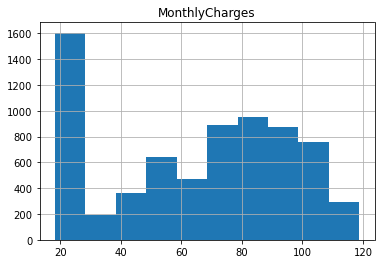

>>> Current breaks:
22.0,26.0,56.0,68.0,106.0 



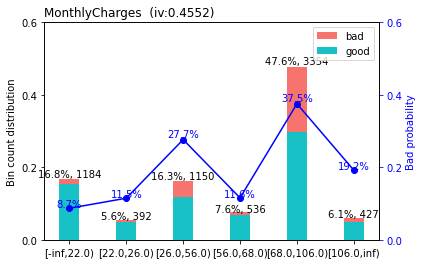

>>> Adjust breaks for (2/8) MonthlyCharges?
1: next 
2: yes 
3: back
Selection: 2
>>> Enter modified breaks: 22.0,26.0,68.0
[INFO] creating woe binning ...
>>> Current breaks:
68.0, 22.0, 26.0 



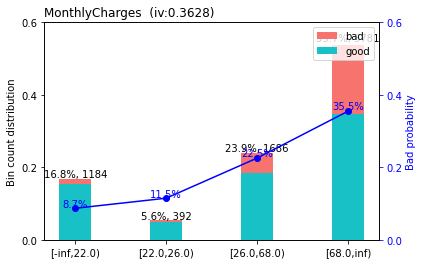

>>> Adjust breaks for (2/8) MonthlyCharges?
1: next 
2: yes 
3: back
Selection: 1
-------- 3/8 PaperlessBilling --------
>>> dt[PaperlessBilling].describe(): 
count     7043
unique       2
top        Yes
freq      4171
Name: PaperlessBilling, dtype: object 

>>> dt[PaperlessBilling].value_counts(): 
Yes    4171
No     2872
Name: PaperlessBilling, dtype: int64 

>>> Current breaks:
'No','Yes' 



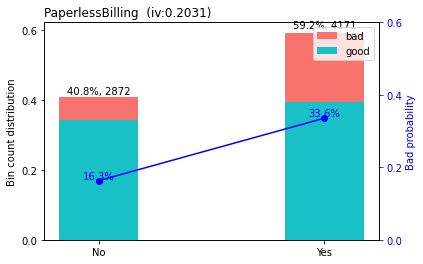

>>> Adjust breaks for (3/8) PaperlessBilling?
1: next 
2: yes 
3: back
Selection: 1
-------- 4/8 Partner --------
>>> dt[Partner].describe(): 
count     7043
unique       2
top         No
freq      3641
Name: Partner, dtype: object 

>>> dt[Partner].value_counts(): 
No     3641
Yes    3402
Name: Partner, dtype: int64 

>>> Current breaks:
'Yes','No' 



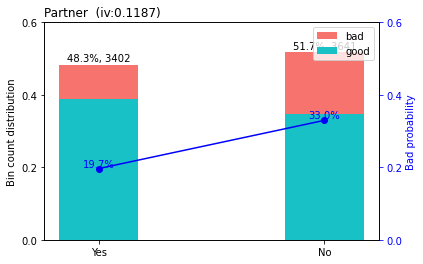

>>> Adjust breaks for (4/8) Partner?
1: next 
2: yes 
3: back
Selection: 1
-------- 5/8 StreamingMovies --------
>>> dt[StreamingMovies].describe(): 
count     7043
unique       3
top         No
freq      2785
Name: StreamingMovies, dtype: object 

>>> dt[StreamingMovies].value_counts(): 
No                     2785
Yes                    2732
No internet service    1526
Name: StreamingMovies, dtype: int64 

>>> Current breaks:
'No internet service','Yes','No' 



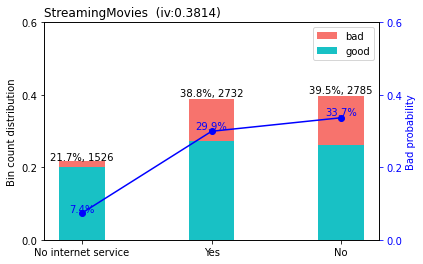

>>> Adjust breaks for (5/8) StreamingMovies?
1: next 
2: yes 
3: back
Selection: 1
-------- 6/8 TechSupport --------
>>> dt[TechSupport].describe(): 
count     7043
unique       3
top         No
freq      3473
Name: TechSupport, dtype: object 

>>> dt[TechSupport].value_counts(): 
No                     3473
Yes                    2044
No internet service    1526
Name: TechSupport, dtype: int64 

>>> Current breaks:
'No internet service','Yes','No' 



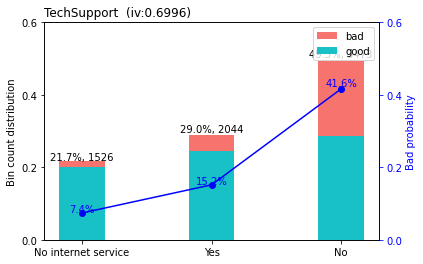

>>> Adjust breaks for (6/8) TechSupport?
1: next 
2: yes 
3: back
Selection: 1
-------- 7/8 TotalCharges --------
>>> dt[TotalCharges].describe(): 
count    7043.000000
mean     2279.797363
std      2266.731934
min        18.799999
25%       398.549988
50%      1394.550049
75%      3786.599976
max      8684.799805
Name: TotalCharges, dtype: float64 



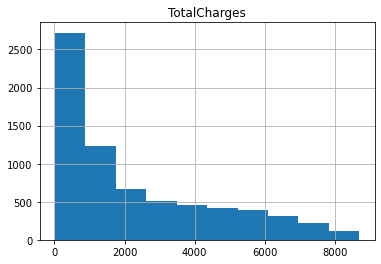

>>> Current breaks:
200.0,400.0,3600.0 



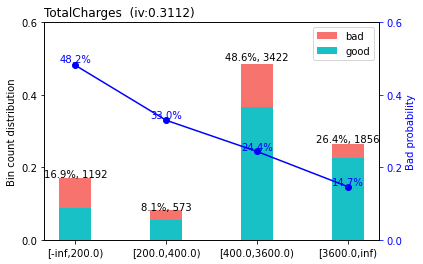

>>> Adjust breaks for (7/8) TotalCharges?
1: next 
2: yes 
3: back
Selection: 1
-------- 8/8 tenure --------
>>> dt[tenure].describe(): 
count    7043.000000
mean       32.371147
std        24.559708
min         0.000000
25%         9.000000
50%        29.000000
75%        55.000000
max        72.000000
Name: tenure, dtype: float64 



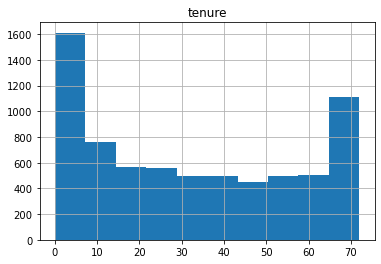

>>> Current breaks:
6.0,18.0,71.0 



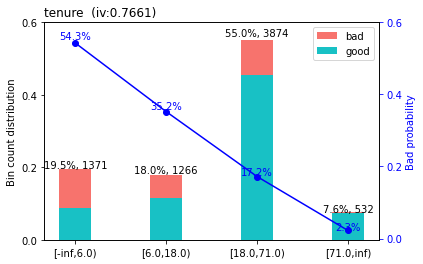

>>> Adjust breaks for (8/8) tenure?
1: next 
2: yes 
3: back
Selection: 1


In [19]:
# binning adjustment
# adjust breaks interactively
breaks_adj = sc.woebin_adj(df_s, "Default", bins) 

In [20]:
# Applying newly adjusted bins
bins_adj = sc.woebin(df_s, y="Default", breaks_list=breaks_adj)

[INFO] creating woe binning ...


In [32]:
# converting train and test into woe values
train_woe = sc.woebin_ply(train, bins_adj)
test_woe = sc.woebin_ply(test, bins_adj)

y_train = train_woe.loc[:,'Default']
X_train = train_woe.loc[:,train_woe.columns != 'Default']
y_test = test_woe.loc[:,'Default']
X_test = test_woe.loc[:,train_woe.columns != 'Default']

[INFO] converting into woe values ...
[INFO] converting into woe values ...


## Modelling

In [22]:
X_train.columns

Index(['MonthlyCharges_woe', 'tenure_woe', 'DeviceProtection_woe',
       'TechSupport_woe', 'Dependents_woe', 'OnlineBackup_woe',
       'PaperlessBilling_woe', 'OnlineSecurity_woe', 'StreamingTV_woe',
       'Contract_woe', 'Partner_woe', 'TotalCharges_woe', 'PaymentMethod_woe',
       'StreamingMovies_woe', 'SeniorCitizen_woe', 'InternetService_woe'],
      dtype='object')

In [77]:
# Exploring Feature Elimination, for initial selection. 1 being the most important based on a specified number of variables.
model = LogisticRegression()
rfe = RFE(model, 10)
fit = rfe.fit(X_train, y_train)

print("Num Features: %s" % (fit.n_features_))
print("Selected Features: %s" % (fit.support_))
print("Feature Ranking: %s" % (fit.ranking_))
print(list(X_train))

Num Features: 10
Selected Features: [ True False  True  True False  True False  True  True  True  True False
  True False  True False]
Feature Ranking: [1 4 1 1 7 1 3 1 1 1 1 6 1 5 1 2]
['SeniorCitizen_woe', 'StreamingTV_woe', 'OnlineSecurity_woe', 'Contract_woe', 'Partner_woe', 'tenure_woe', 'Dependents_woe', 'StreamingMovies_woe', 'PaymentMethod_woe', 'InternetService_woe', 'PaperlessBilling_woe', 'DeviceProtection_woe', 'TotalCharges_woe', 'MonthlyCharges_woe', 'OnlineBackup_woe', 'TechSupport_woe']


C:\Users\justi\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_features_to_select=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [42]:
# Variables manually dropped depending on (1) non-significance seen in the logistic regression output amd (2) VIF > 4
top_vars = ['SeniorCitizen_woe', 'OnlineSecurity_woe',
            'Contract_woe', 'tenure_woe',
            'PaymentMethod_woe', 'InternetService_woe',
            'PaperlessBilling_woe', 'TotalCharges_woe'
            ]

X_train = X_train[top_vars]
X_test = X_test[top_vars]

In [43]:
# logistic regression ------
X_train_cons = sm.add_constant(X_train)
X_test_cons = sm.add_constant(X_test)

logit_model=sm.Logit(y_train,X_train_cons)

ri=logit_model.fit()
ri.summary()

Optimization terminated successfully.
         Current function value: 0.421288
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                Default   No. Observations:                 4930
Model:                          Logit   Df Residuals:                     4921
Method:                           MLE   Df Model:                            8
Date:                Mon, 20 Dec 2021   Pseudo R-squ.:                  0.2718
Time:                        15:23:19   Log-Likelihood:                -2076.9
converged:                       True   LL-Null:                       -2852.2
Covariance Type:            nonrobust   LLR p-value:                     0.000
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -1.0150      0.041    -24.676      0.000      -1.096      -0.934
SeniorCitizen_woe        0.3970      0.117      3.405      0.001       0.169       0.625
OnlineSecurity_woe       0.1944      0.059      3.271      0.001       0.078       0.311
Contract_woe             0.4420      0.048      9.149      0.000       0.347       0.537
tenure_woe               0.4543      0.083      5.499      0.000       0.292       0.616
PaymentMethod_woe        0.2403      0.058      4.120      0.000       0.126       0.355
InternetService_woe      0.8822      0.075     11.697      0.000       0.734       1.030
PaperlessBilling_woe     0.4097      0.094      4.380      0.000       0.226       0.593
TotalCharges_woe         0.6278      0.128      4.901      0.000       0.377       0.879
========================================================================================
"""

In [44]:
# VIF
variables = ri.model.exog
vif = [variance_inflation_factor(variables, i) for i in range(variables.shape[1])]
vif 

[1.1220437630824356,
 1.0885377093284851,
 2.2161139214677896,
 2.014629543741741,
 2.7128233461634554,
 1.2676250551775627,
 2.6902601253651457,
 1.2096810006050487,
 2.8969155703048006]

In [45]:
class Model:
    coef_ = np.array([ri.params.drop('const')])
    intercept_ = np.array([ri.params.const])

In [46]:
# predicted proability
train_pred = ri.predict(X_train_cons)
test_pred = ri.predict(X_test_cons)

C:\Users\justi\anaconda3\lib\site-packages\scorecardpy\perf.py:318: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(subplot_nrows,subplot_ncols,i+1)
C:\Users\justi\anaconda3\lib\site-packages\scorecardpy\perf.py:318: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(subplot_nrows,subplot_ncols,i+1)


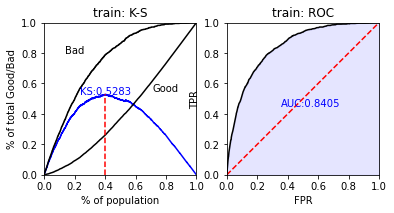

C:\Users\justi\anaconda3\lib\site-packages\scorecardpy\perf.py:318: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(subplot_nrows,subplot_ncols,i+1)
C:\Users\justi\anaconda3\lib\site-packages\scorecardpy\perf.py:318: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(subplot_nrows,subplot_ncols,i+1)


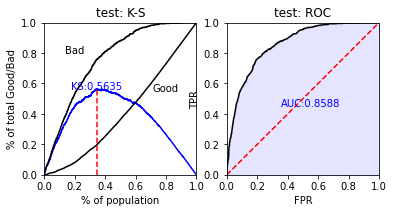

In [47]:
# performance ks & roc ------
train_perf = sc.perf_eva(y_train, train_pred, title = "train")
test_perf = sc.perf_eva(y_test, test_pred, title = "test")

# KS is used as it measures how different two distributions are. KS is the maximum difference between 
# the cumulative percent good distribution and the cumulative percent bad distribution. 53-56 max separation for test
# and train data is already great as industry practices lie between 20-70

# ROC curve is another graphical method of assessing discriminatory power. The ROC curves plot the SENSITIVITY 
# or the proportion of correctly classified good loans above the cutoff score on the vertical axis against 
# the (1 – SPECIFICITY) or the proportion of bad accounts above the cutoff score on the horizontal axis. 
# A model has more accuracy as the curve moves to the upper left

# From the ROC curve, another graphic measure of discriminatory power can be derived which is the Area under Curve (AUC). 
# It simply refers to the area under the ROC curve and the larger the area the more accurate the model. A model with 
# very high accuracy would have had an AUC close to 1. The AUC can be interpreted as the average ability of the model 
# to accurately predict good and bad borrowers. In the dev sample, the AUC is already at 0.84 which is a performance value

# Gini is another metric to describe the separation power from Good/Bad, the ideal model should have a Gini index equal to 1.
# Train and test sample reports 0.68 and 0.72 respectively which are good numbers

In [48]:
pd.DataFrame.from_dict(train_perf,orient='index')

,0
KS,0.5283
AUC,0.8405
Gini,0.6809
pic,Figure(432x288)


In [49]:
pd.DataFrame.from_dict(test_perf,orient='index')

,0
KS,0.5635
AUC,0.8588
Gini,0.7176
pic,Figure(432x288)


In [50]:
# score ------
card = sc.scorecard(bins_adj, Model, X_train.columns)

C:\Users\justi\anaconda3\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\justi\anaconda3\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


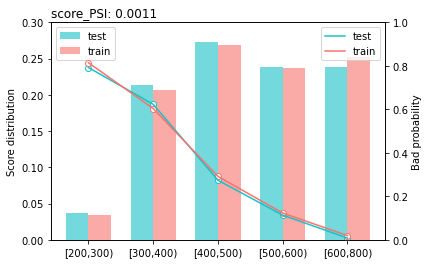

In [51]:
# credit score
train_score = sc.scorecard_ply(train, card, print_step=0)
test_score = sc.scorecard_ply(test, card, print_step=0)

# psi
psi = sc.perf_psi(
  score = {'train':train_score, 'test':test_score},
  label = {'train':y_train, 'test':y_test},
    x_tick_break = 100
)

# fig = psi['pic']['score']
# fig.set_size_inches(15,12)
# fig

# The main purpose of application soring model is to rank order risk which means individuals with higher scores 
# are anticipated to manage their loans better than those with lower scores. There is also a consistent decreasing pattern 
# of bad rates across the entire score ranges which tells that the model is able to successfully rank order risk of individuals

# PSI is a widely used statistic that measures how much a variable has shifted over time. For the developemnt of the model,
# PSI is steady with a value of below 0.10.


In [52]:
# Full scoring weights 
card

{'basepoints':      variable  bin  points
 0  basepoints  NaN     461,
 'SeniorCitizen':          variable bin  points
 19  SeniorCitizen   0     4.0
 20  SeniorCitizen   1   -20.0,
 'OnlineSecurity':          variable                  bin  points
 3  OnlineSecurity  No internet service    21.0
 4  OnlineSecurity                  Yes    10.0
 5  OnlineSecurity                   No   -10.0,
 'Contract':     variable             bin  points
 9   Contract        Two year    80.0
 10  Contract        One year    33.0
 11  Contract  Month-to-month   -23.0,
 'tenure':    variable          bin  points
 28   tenure   [-inf,6.0)   -39.0
 29   tenure   [6.0,18.0)   -13.0
 30   tenure  [18.0,71.0)    18.0
 31   tenure   [71.0,inf)    90.0,
 'PaymentMethod':          variable                                                bin  points
 42  PaymentMethod  Credit card (automatic)%,%Bank transfer (autom...    11.0
 43  PaymentMethod                                       Mailed check     7.0
 44  Payme